In [3]:
from typing import List

import numpy as np
import torch as t
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import animation, cm, cbook

from tqdm.notebook import tqdm

import jax

Counter({(0.0, 0.0): 10014,
         (0.0, 1.0): 5053,
         (1.0, 0.0): 4939,
         (0.0, -1.0): 4988,
         (0.0, -2.0): 4998,
         (0.0, -3.0): 5007,
         (0.0, 2.0): 5004,
         (0.0, 3.0): 4838,
         (-1.0, 0.0): 5095,
         (-2.0, 0.0): 5128,
         (-3.0, 0.0): 5060,
         (-4.0, 0.0): 5094,
         (2.0, 0.0): 5000,
         (3.0, 0.0): 5102,
         (4.0, 0.0): 5180,
         (-5.0, 0.0): 5210,
         (0.0, 4.0): 4698,
         (0.0, -5.0): 4708,
         (0.0, -4.0): 4884})

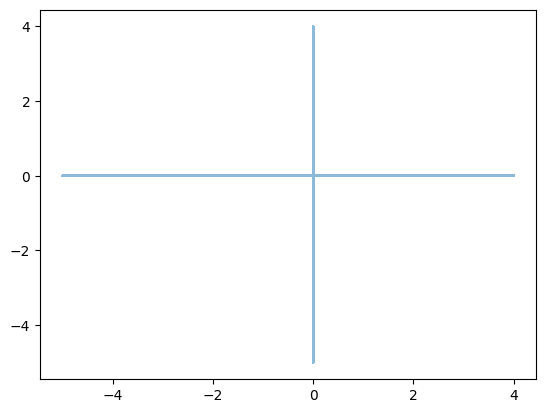

In [41]:
from collections import Counter


def walk_crossing_lattice(n: int, D=2, l=5) -> np.ndarray:
    """Generate a random walk on D x 1D random walks that intersect at 0.
    """
    walk = np.zeros((n, D))
    origin = np.zeros(D)

    for i in range(1, n):
        direction = np.random.choice([-1, 1])

        if np.all(walk[i - 1] == origin):
            axis = np.random.randint(D)
            walk[i, axis] = direction
        else:
            axis = np.abs(walk[i - 1]).argmax()
            step = np.zeros(D)
            step[axis] = direction
            walk[i, :] = walk[i - 1] + step

        # Toroidal boundary conditions (-l, l)
        walk[i, :] = np.mod(walk[i, :] + l, 2 * l) - l 

    return walk

walk = walk_crossing_lattice(100_000, D=2)

plt.plot(walk[:, 0], walk[:, 1], alpha=0.5)

count = Counter([tuple(x) for x in walk])
count

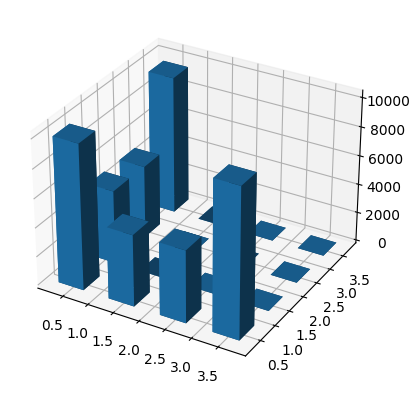

In [46]:

# plt.plot(walk[:, 0], walk[:, 1], alpha=0.5)

# Plot 3D histogram

def plot_3d_hist(walk: np.ndarray, bins: int = 100, cmap: str = "viridis"):
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")

    x, y = walk[:, 0], walk[:, 1]
    hist, xedges, yedges = np.histogram2d(x, y, bins=int(y.max()), range=[[0, 4], [0, 4]])

    # Construct arrays for the anchor positions of the 16 bars.
    xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0

    # Construct arrays with the dimensions for the 16 bars.
    dx = dy = 0.5 * np.ones_like(zpos)
    dz = hist.ravel()

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

    plt.show()

plot_3d_hist(walk, bins=100)

/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_61714/1932912155.py:13: RuntimeWarning: invalid value encountered in sqrt
  ymins = np.sqrt(x ** 2 * (x + 1))


(<Figure size 1000x1000 with 1 Axes>,
 <AxesSubplot: title={'center': 'Double Point singularity'}, xlabel='x', ylabel='y'>)

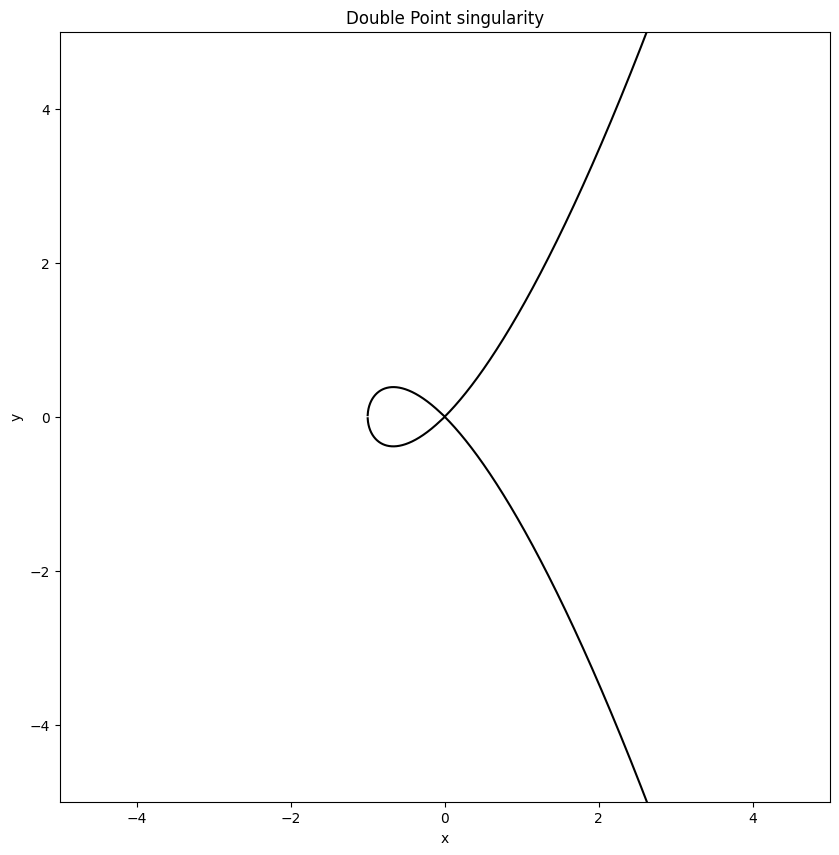

In [8]:
def plot_double_pt_singularity(xlim=(-5, 5), ylim=(-5, 5)):
    # y2 − x2(x + 1) = 0

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect("equal")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Double Point singularity")

    x = np.linspace(*xlim, 10000)
    ymins = np.sqrt(x ** 2 * (x + 1))
    ymaxs = -ymins

    ax.plot(x, ymins, color="black")
    ax.plot(x, ymaxs, color="black")

    return fig, ax

plot_double_pt_singularity()

/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_61714/1932912155.py:13: RuntimeWarning: invalid value encountered in sqrt
  ymins = np.sqrt(x ** 2 * (x + 1))


(<Figure size 1000x1000 with 1 Axes>,
 <AxesSubplot: title={'center': 'Double Point singularity'}, xlabel='x', ylabel='y'>)

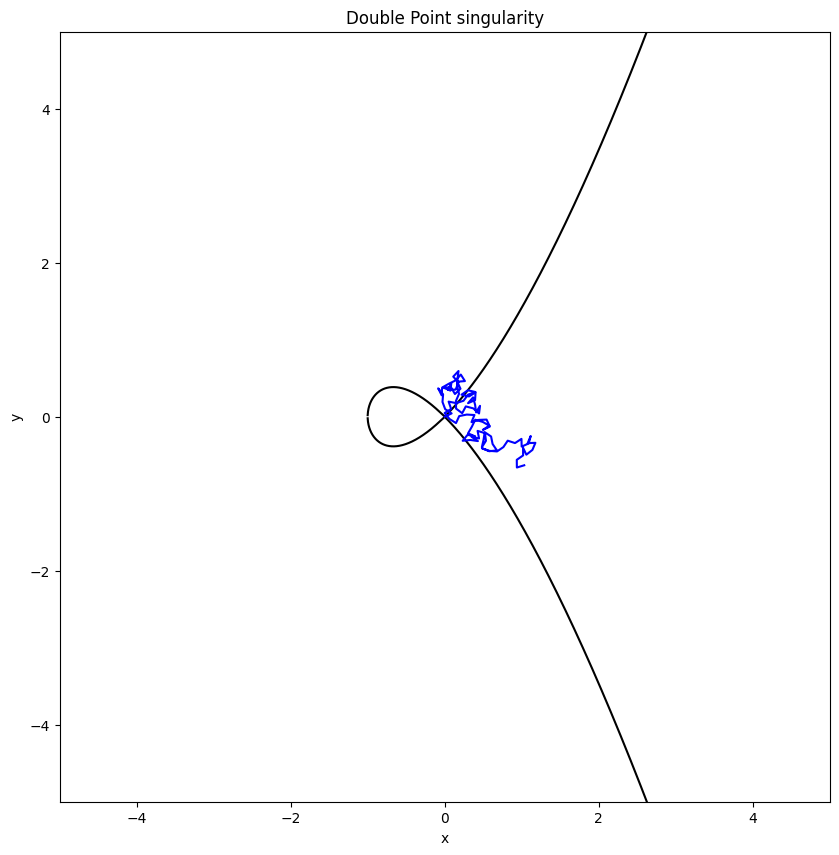

In [9]:
# Perform a random walk restricted to a plane curve

from typing import Callable


def random_walk_on_curve(
    curve: Callable[[np.ndarray], np.ndarray],
    n_steps: int,
    start: np.ndarray,
    step_size: float = 1.0,
) -> np.ndarray:
    """Perform a random walk on a curve.

    Parameters
    ----------
    curve : Callable[[np.ndarray], np.ndarray]
        The curve to walk on.
    n_steps : int
        The number of steps to take.
    start : np.ndarray
        The starting point of the walk.
    step_size : float, optional
        The step size, by default 1.0

    Returns
    -------
    np.ndarray
        The trajectory of the walk.
    """
    trajectory = [start]

    for _ in range(n_steps):
        # Sample a direction
        direction = np.random.randn(2)

        # Normalize the direction
        direction /= np.linalg.norm(direction)

        # Take a step
        trajectory.append(trajectory[-1] + step_size * direction)

    return np.array(trajectory)

def plot_random_walk_on_curve(
    curve: Callable[[np.ndarray], np.ndarray],
    n_steps: int,
    start: np.ndarray,
    step_size: float = 1.0,
    xlim=(-5, 5),
    ylim=(-5, 5),
):
    trajectory = random_walk_on_curve(curve, n_steps, start, step_size)

    fig, ax = plot_double_pt_singularity(xlim, ylim)

    ax.plot(trajectory[:, 0], trajectory[:, 1], color="blue")

    return fig, ax

plot_random_walk_on_curve(
    lambda x: np.sqrt(x ** 2 * (x + 1)),
    100,
    np.array([0, 0]),
    step_size=0.1,
)